# Weight Decay

One of regularization techniques

## Implementation from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

### Data Generation

$y=0.05 + \Sigma_{i=1}^d 0.01 x_i+\epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.01^2)$.

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### Initialize Model 

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### Regularization

$l(w, b) + \frac{\lambda}{2}||w||^2$

$l(w, b) + \lambda |w|$

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [15]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

### Training

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X), y) + lambd * l2_penalty(w) # add l2 penalty ###
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of weight is：', torch.norm(w).item())

No regularization

L2 norm of weight is： 13.623512268066406


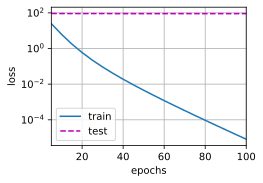

In [7]:
train(lambd=0)

The figure shows overfitting.

Regularization

L2 norm of weight is： 0.33807069063186646


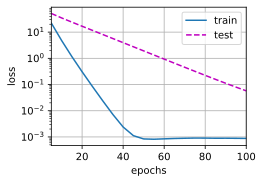

In [8]:
train(lambd=3)

The figure shows regularization, but not as much as previous case.

L2 norm of weight is： 0.05413974076509476


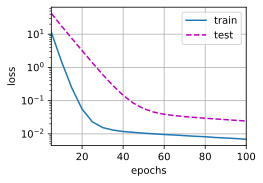

In [9]:
train(lambd=7)

## Concise Implementation

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, { # weight decay ######
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of weight is：', net[0].weight.norm().item())

L2 norm of weight is： 13.175877571105957


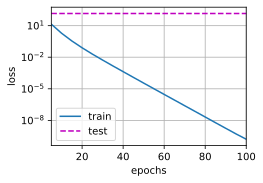

In [11]:
train_concise(0)

L2 norm of weight is： 0.4487416446208954


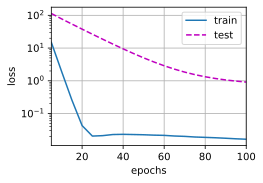

In [12]:
train_concise(3)

L2 norm of weight is： 0.24415448307991028


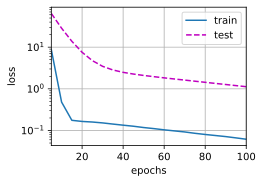

In [13]:
train_concise(7)